In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from evaluation import evaluate_model
from preprocessing import run_feature_engineering
from sklearn import preprocessing
import xgboost as xgb
import gc

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

sns.set_theme(
    style="whitegrid",       # Background style ("whitegrid", "darkgrid", etc.)
    palette="deep",          # Default color palette ("deep", "muted", "bright", etc.)
    font="sans-serif",       # Font family
    font_scale=1.1,          # Scale font size slightly
    rc={"figure.figsize": (8, 5)}  # Default figure size
)

c:\Users\Ahmed Osama\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = Path("../datasets")

train_identity = pd.read_csv(dataset_path / "train_identity.csv")
train_tx = pd.read_csv(dataset_path / "train_transaction.csv")

# test_identity = pd.read_csv(dataset_path / "test_identity.csv")
# test_tx = pd.read_csv(dataset_path / "test_transaction.csv")

In [3]:
train_all_cols = pd.merge(train_tx, train_identity, on='TransactionID', how='left')
# test_all_cols = pd.merge(train_tx, train_identity, on='TransactionID', how='left')

X =  train_all_cols.drop(columns=['isFraud'])
y = train_all_cols['isFraud']

In [4]:
print(f"X_shape: {X.shape}")

X_shape: (590540, 433)


In [19]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

In [ ]:
high_missing_cols = [col for col in X_train.columns if X_train[col].isnull().sum() / X_train.shape[0] > 0.96]
high_missing_cols_X_test = [col for col in X_test.columns if X_test[col].isnull().sum() / X_test.shape[0] > 0.96]

big_top_value_cols = [col for col in X_train.columns if X_train[col].value_counts(dropna=False, normalize=True).values[0] > 0.96]
big_top_value_cols_X_test = [col for col in X_test.columns if X_test[col].value_counts(dropna=False, normalize=True).values[0] > 0.96]

cols_to_drop = list(set(high_missing_cols + high_missing_cols_X_test + big_top_value_cols + big_top_value_cols_X_test ))
len(cols_to_drop)
print(cols_to_drop)


X_train = X_train.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)


X_train.drop('TransactionDT', axis=1, inplace=True)
X_test.drop('TransactionDT', axis=1, inplace=True)

print(X_train.shape)
print(X_test.shape)

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values)) 
        
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

['V119', 'V116', 'V118', 'id_27', 'V114', 'V111', 'C3', 'V108', 'id_07', 'V110', 'V286', 'id_23', 'V301', 'V112', 'V123', 'V113', 'V120', 'V311', 'V109', 'V122', 'id_26', 'id_24', 'id_21', 'V115', 'V305', 'id_25', 'id_22', 'id_08', 'V107', 'V300', 'V117', 'V121']
(377945, 400)
(118108, 400)


In [7]:
# from imblearn.over_sampling import KMeansSMOTE

# print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
# print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

# sm = KMeansSMOTE(random_state=99, sampling_strategy = 0.15,  k_neighbors = 10,cluster_balance_threshold = 0.02, n_jobs=4)
# X_train_new, y_train_new = sm.fit_resample(X_train, y_train.ravel())

# X_train_new = pd.DataFrame(X_train_new)
# X_train_new.columns = X_train.columns
# y_train_new = pd.DataFrame(y_train_new)

# print('After OverSampling, the shape of X_train_new: {}'.format(X_train_new.shape))
# print('After OverSampling, the shape of y_train_new: {} \n'.format(y_train_new.shape))

# print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
# print("After OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

In [8]:
# from sklearn.model_selection import StratifiedKFold
# import xgboost as xgb
# import numpy as np
# import gc

# EPOCHS = 4
# kf = StratifiedKFold(n_splits=EPOCHS, random_state=99, shuffle=True)

# y_preds = np.zeros(X_test.shape[0])
# y_oof = np.zeros(X_train_new.shape[0])

# for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train_new, y_train_new)):
#     print(f"\n🚀 Fold {fold + 1}/{EPOCHS}")
    
#     X_tr, X_val = X_train_new.iloc[tr_idx], X_train_new.iloc[val_idx]
#     y_tr, y_val = y_train_new.iloc[tr_idx], y_train_new.iloc[val_idx]

#     model = xgb.XGBClassifier(
#         n_estimators=500,
#         max_depth=17,
#         learning_rate=0.03,
#         subsample=0.9,
#         colsample_bytree=0.9,
#         tree_method='hist',
#         use_label_encoder=False,
#         eval_metric='auc',
#         missing=-999,
#         random_state=42
#     )

#     model.fit(X_tr, y_tr)
#     val_preds = model.predict_proba(X_val)[:, 1]
#     test_preds = model.predict_proba(X_test)[:, 1]

#     y_oof[val_idx] = val_preds
#     y_preds += test_preds / EPOCHS

#     evaluate_model(
#         model,
#         X_val,
#         y_val,
#         X_test,
#         y_test,
#         threshold=0.5,
#         model_name="XGBoost",
#         is_lightgbm=False
#     )

# print("\n📊 Final OOF Evaluation:")
# evaluate_model(
#     model,
#     X_val,
#     y_val,
#     X_test,
#     y_test,
#     threshold=0.5,
#     model_name="XGBoost",
#     is_lightgbm=False
# )
# del X_train_new
# gc.collect()


In [ ]:
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=17,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method='hist',
    use_label_encoder=False,
    eval_metric='auc',
    missing=-999,
    random_state=42
)

model.fit(X_train, y_train)

c:\Users\Ahmed Osama\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:36:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:ProductCD: object, card4: object, card6: object, P_emaildomain: object, R_emaildomain: object, M1: object, M2: object, M3: object, M4: object, M5: object, M6: object, M7: object, M8: object, M9: object, id_12: object, id_15: object, id_16: object, id_23: object, id_27: object, id_28: object, id_29: object, id_30: object, id_31: object, id_33: object, id_34: object, id_35: object, id_36: object, id_37: object, id_38: object, DeviceType: object, DeviceInfo: object


Validation Metrics:
AUC: 0.9689
Accuracy: 0.9851
Precision: 0.9618
Recall: 0.5976
F1 Score: 0.7372
Log Loss: 0.0519
Brier Score: 0.0123
Average Precision: 0.8321

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    113975
           1       0.96      0.60      0.74      4133

    accuracy                           0.99    118108
   macro avg       0.97      0.80      0.86    118108
weighted avg       0.98      0.99      0.98    118108

Confusion Matrix:
[[113877     98]
 [  1663   2470]]


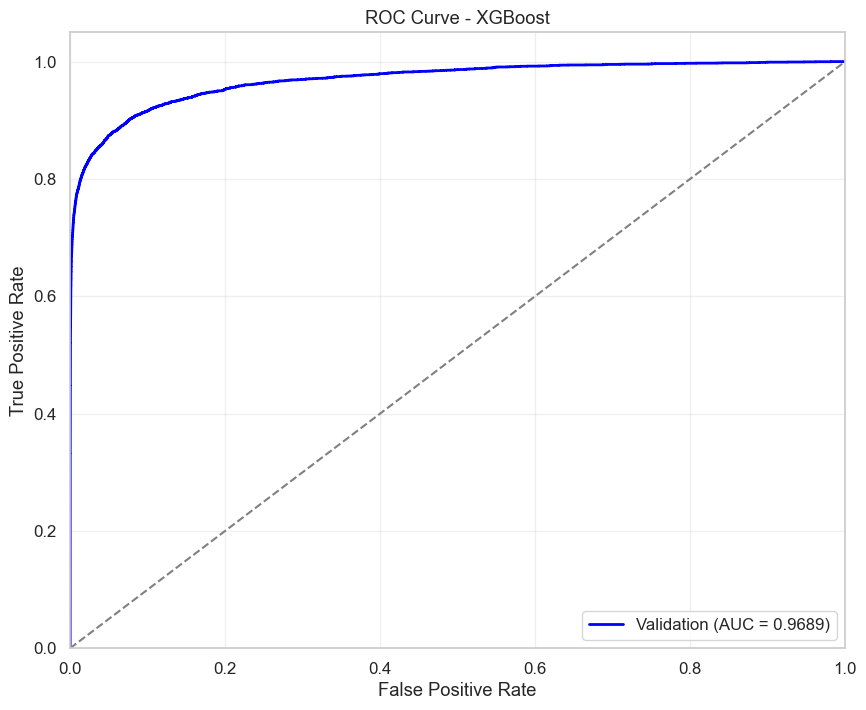

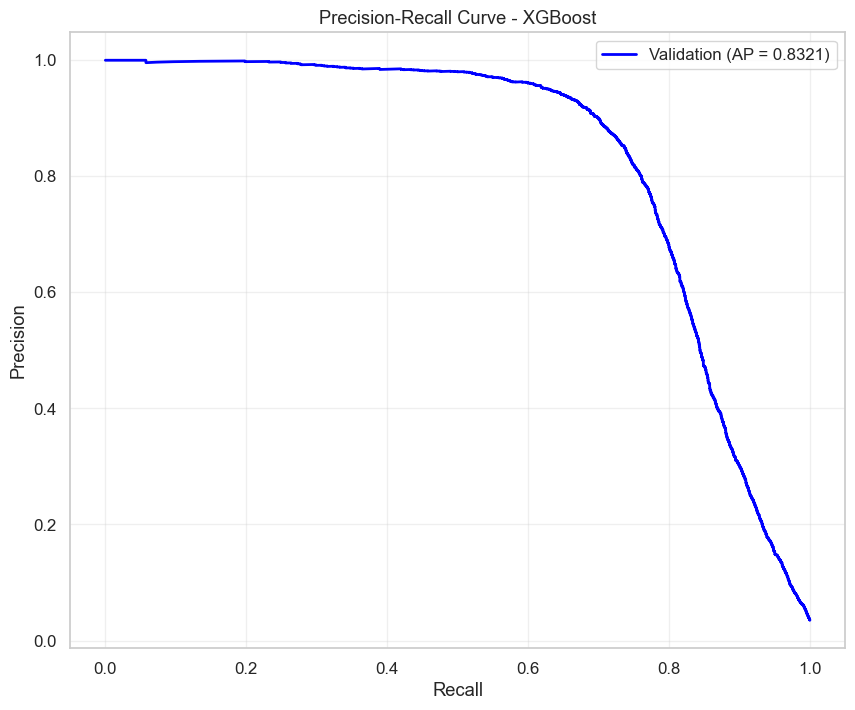

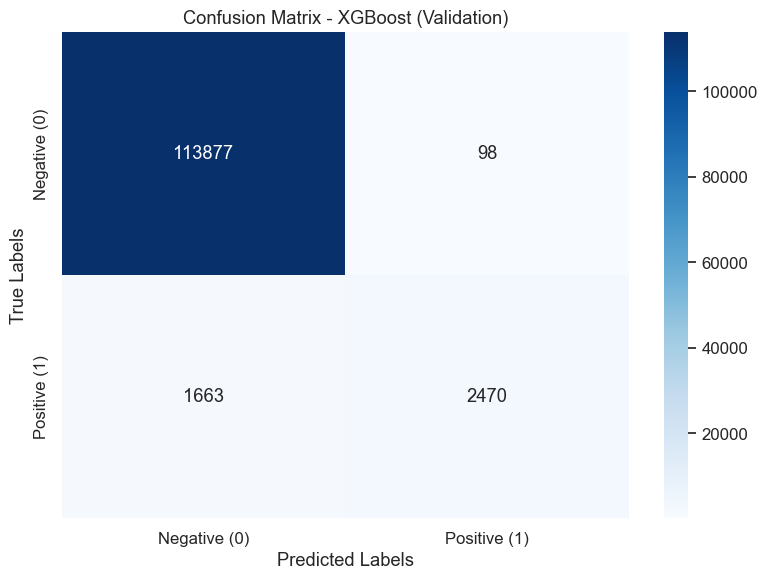

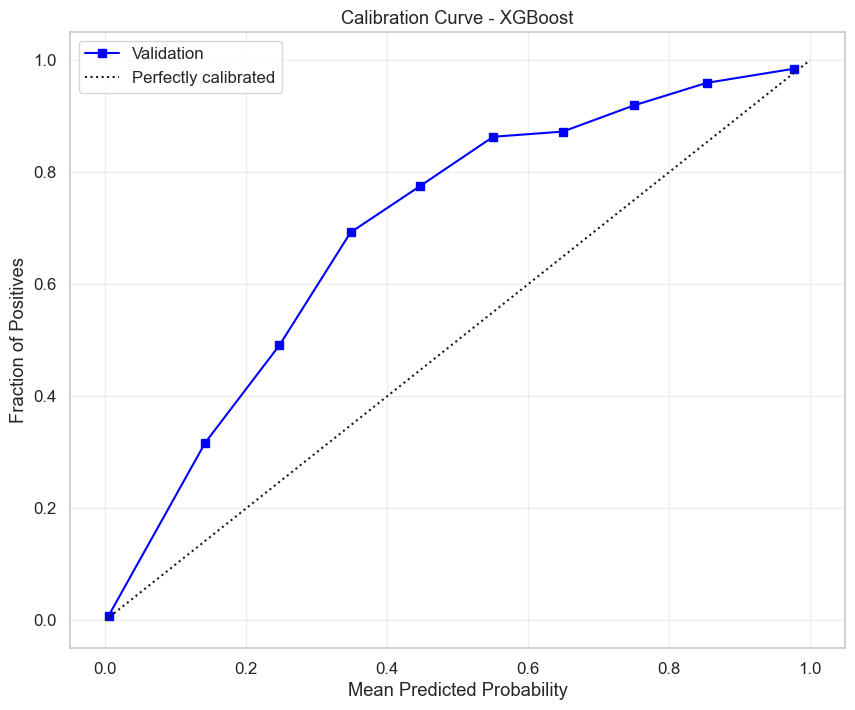

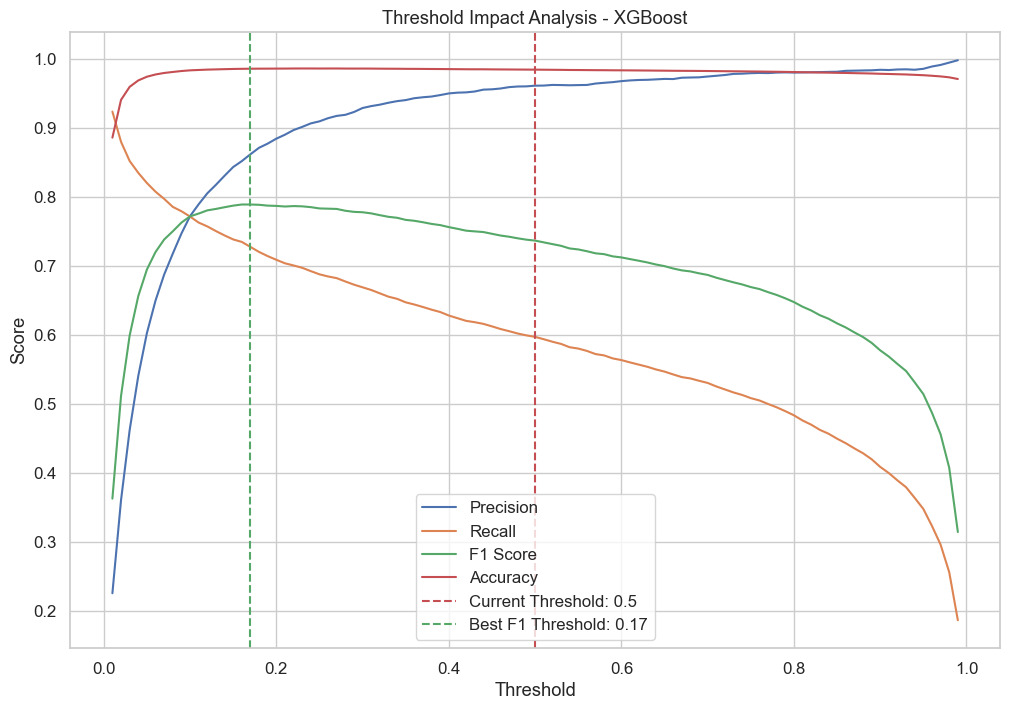

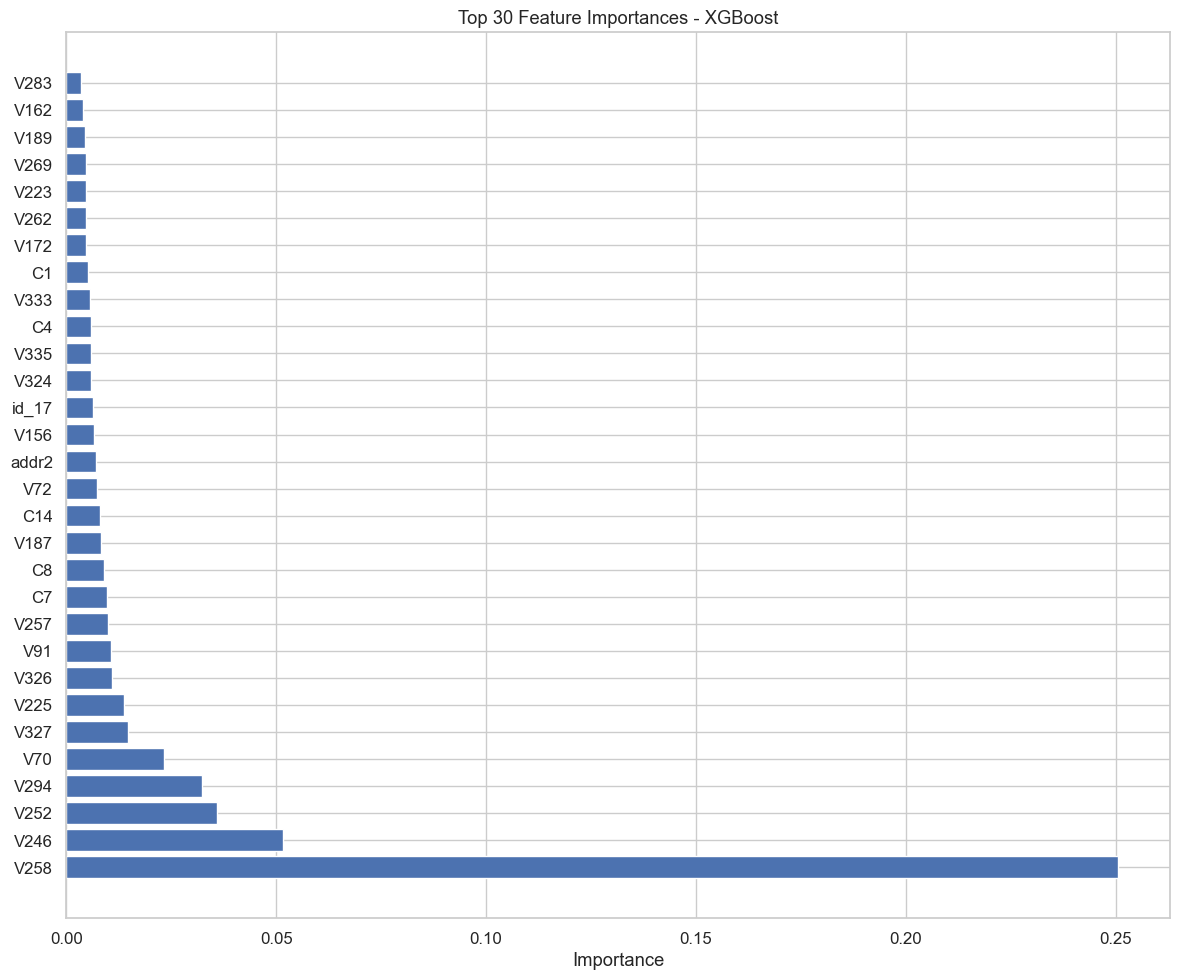

29389

In [21]:
evaluate_model(
    model,
    X_test,
    y_test,
    None,
    None,
    threshold=0.5,
    model_name="XGBoost",
    is_lightgbm=False
)

gc.collect()